# Chapter 3 - Exercise 5
#### Author: *John Benedick Estrada*
---
**Exercise:** A natural question about the Watts and Strogatz paper is whether the small world phenomenon is specific to their generative model or whether other similar models yield the same qualitative result (high clustering and low path lengths). To answer this question, choose a variation of the Watts and Strogatz model and repeat the experiment. There are two kinds of variation you might consider:

- Instead of starting with a regular graph, start with another graph with high clustering. For example, you could put nodes at random locations in a 2-D space and connect each node to its nearest k neighbors.
- Experiment with different kinds of rewiring

If a range of similar models yield similar behavior, we say that the results of the paper are **robust**.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import networkx as nx
import numpy as np
from utils import decorate
from typing import Iterator, Iterable, Hashable

Initialize a random number generator

### New scheme for rewiring graphs.

Instead of providing the probabililty of rewiring, the number of edgess to be rewired is to be provided.

In [3]:
def new_rewire(G: nx.Graph, rewire_count: int):
    nodes = set(G)
    for i, (u, v) in enumerate(G.edges()):
        if i < rewire_count:
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)

Function for generating ring lattices. These are from the book.

In [4]:
def adjacent_edges(nodes: Iterator, halfk: int):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


def make_ring_lattice(n: int, k: int):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

Function to generate "WS" graph with the new scheme

In [5]:
def make_new_ws_graph(n: int, k: int, p: int):
    ws = make_ring_lattice(n, k)
    new_rewire(ws, p)
    return ws

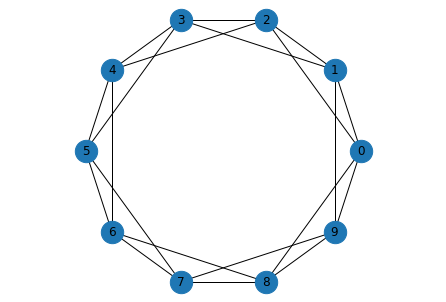

In [6]:
G = make_new_ws_graph(10, 4, 0)

nx.draw_circular(G,
                 node_color='C0',
                 node_size=500, 
                 with_labels=True)
plt.axis("equal")
plt.show()

### WS experiment
Redoing the WS experiment with the new graph generation scheme.

##### Characteristic path length
Function definitions are lifted from the book with some modifications.

In [7]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist


def characteristic_path_length(G):
    # Cumulative mean.
    mean = 0.
    for N, length in enumerate(path_lengths(G)):
        mean = (length + N*mean)/(N + 1)

    return mean

##### Clustering coefficient
Function definitions are directly lifted from the book.

In [8]:
def node_clustering(G: nx.Graph, u: Hashable):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return float("nan")
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible


def all_pairs(nodes: Iterator[Hashable]):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v


def clustering_coefficient(G: nx.Graph):
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In [9]:
def run_one_graph(n: int, k: int, r: int):
    """
    Run the WS experiment on one graph.
    
    Parameters:
    -----------
    n:    int
        Number of nodes.
    k:    int
        Number of neighbors for each nodes.
    r:    int
        Number of edges to be rewired.
    """
    ws = make_new_ws_graph(n, k, r)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(f"{mpl:5.15f} | {cc:5.15f}")
    return mpl, cc

In [23]:
# Return set of numbe of edges to be rewired.
def get_rs(n, k, num=None):
    """
    Return a list of number of edges to be rewired for a given number of nodes
    from a ring lattice.
    
    Parameters:
    -----------
    n:    int
        Number of nodes.
    k:    int
        Number of neighbors for each node.
    num:  int
        Number of elements in the list to be returned.
    """
    if n > k:
        if k % 2 == 0:
            all_edges = n*k//2
        else:
            raise ValueError("k must be even")
    else:
        raise ValueError("n must be greater than k")
        

    if num is None:
        step = 1
    else:
        step = all_edges//num
    return [i for i in range(0, all_edges+1, step)]

In [24]:
def run_new_experiment(n: int=1000, k: int=10, iters: int=20, rewire_count: int=None):
    """
    Run the WS experiment over a set of graphs generated with the new
    rewiring scheme.

    Parameters:
    -----------
    n:     int
        Number of nodes.
    k:     int
        Number of neighbors of each nodes.
    iters: int
        Number of iterations.
    rewire_count: int
        Number of edges to be rewired. If `None`, it is set to the number of
        all possible edges with the provided values for `n` and `k`.
    """
    res = []
    for r in get_rs(n, k, rewire_count):
        print(f"Number of edges to be rewired: {r}")
        header = " Characteristic path length | Clustering coefficient"
        print("-"*len(header))
        print(header)
        print("-"*len(header))
        t = [run_one_graph(n, k, r) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print("Mean:")
        print(f"{means[0]:5.15f} | {means[1]:5.15f}")
        print("-"*len(header) + "\n")
        res.append(means)
    return np.array(res)

In [25]:
%time result = run_new_experiment(n=1000, k=10, rewire_count=10)

Number of edges to be rewired: 0
----------------------------------------------------
 Characteristic path length | Clustering coefficient
----------------------------------------------------
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
50.399999999999132 | 0.666666666666667
Mean:
50.399999999999153 | 0

In [26]:
L, C = np.transpose(result)
L /= L[0]
C /= C[0]

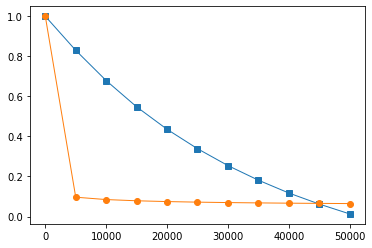

In [31]:
rs = get_rs(n=1000, k=100, num=10)
plt.plot(rs, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(rs, L, 'o-', linewidth=1, label='L(p) / L(0)')
plt.show()